## Non-linear Support Vector Machine

For a given data set, if a hypersurface can be used to correctly separate positive and negative instances, the problem is a nonlinearly separable problem. A key for solving the nonlinear problem is to transform the original data space into a new data space. The nonlinearly separable problem will be a linearly separable problem in the new data space.

Generally speaking, there are two steps when using linearly separable method to solve the nonlinearly separable problem. First, a transformation is used to map the data in the original space to the new space, and then the classification model is trained in the new space using the linear classification learning method. This method of transforming the original space into the new space is called the kernel trick. 

Assuming that there is a map from input space to feature space, and function $K(x, z)=\&(x).\&(z)$ exists for all $x$ and $z$, then $K(x, z)$ is called kernel function. In practical problems, the form of the kernel function is usually given directly and then used to solve the problem. Commonly used kernel functions include polynomial kernel function, Gaussian kernel function and sigmoid kernel function, etc.

$$
\begin{array}{lcc}
\text { Type of kernel } & \text { Kernel function } & \begin{array}{c}
\text { Kernel } \\
\text { parameter }
\end{array} \\
\hline \text { Polynomial } & ((x \cdot y)+1)^{d} & d \\
\text { Gaussian radial basis function } & \exp \left[-\frac{|x-y|^{2}}{2 \sigma^{2}}\right] & \sigma \\
\text { Multilayer } & \tanh \left(\beta_{t}(x \cdot y)+\beta_{o}\right) & \beta_{o} \beta_{l} \\
\text { perceptron } & 
\begin{array}{c}
1+x y+x y \min (x, y)- \\ 
\frac{(x+y)}{2}(\min (x, y))^{2} + \frac{1}{3}(\min (x, y))^{3}
\end{array} & - \\
\hline
\end{array}
$$

The dual optimization problem of nonlinear support vector machine based on kernel function is as follows:

$$
\begin{gathered}
\min _{\vec{\alpha}} \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} \tilde{y}_{i} \tilde{y}_{j} K\left(\overrightarrow{\mathbf{x}}_{i}, \overrightarrow{\mathbf{x}}_{j}\right)-\sum_{i=1}^{N} \alpha_{i} \\
\text { s.t. } \quad \sum_{i=1}^{N} \alpha_{i} \tilde{y}_{i}=0 \\
C \geq \alpha_{i} \geq 0, i=1,2, \cdots, N
\end{gathered}
$$

When the kernel function is a positive definite kernel, the above optimization problem is a convex optimization problem and can be solved directly. The optimal solution can be obtained from :
$$
\overrightarrow{\alpha}^{*} = (\alpha ^{*} _{1}, \alpha ^{*} _{2}, \cdots ,\alpha ^{*} _{N})^{\top}
$$

Calculate $\mathbf{w}$ as follow:
$$
\overrightarrow{\mathbf{w}}^{*} = \sum ^{N} _{i=1} \alpha ^{*} _{i} \tilde{y}_{j} \overrightarrow{\mathbf{x}}_{i}
$$

The classification decision function is:
$$
f(\overrightarrow{\mathbf{x}}) = \text{sign}(\sum ^{N} _{i=1} \alpha ^{*} _{i} \tilde{y}_{j} K(\overrightarrow{\mathbf{x}}_{i}, \overrightarrow{\mathbf{x}})+b^{*})
$$

Although the convex optimization problem can be solved directly, when the amount of data is large, the direct solution will be very inefficient. At this time, some efficient training algorithms are required, such as the Sequence Minimum Optimization algorithm.

In [38]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# generate sample data
def gen_non_linear_sep_data():
    mean1, mean2, mean3, mean4 = [-1, 2], [1, -1], [4, -4], [-4, 4]
    cov = [[1.0, 0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = -1 * np.ones(len(X2))
    X_train = np.vstack((X1[:80], X2[:80]))
    y_train = np.hstack((y1[:80], y2[:80]))
    X_test = np.vstack((X1[80:], X2[80:]))
    y_test = np.hstack((y1[80:], y2[80:]))

    return X_train, y_train, X_test, y_test

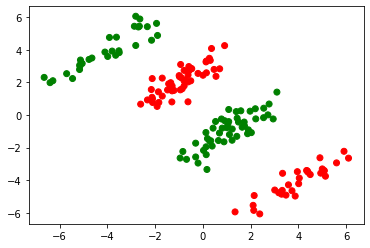

In [40]:
X_train, y_train, X_test, y_test = gen_non_linear_sep_data()
colors = {1:'r', -1:'g'}
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=pd.Series(y_train).map(colors))
plt.show()

In [41]:
# define the polynomial kernel
def polynomial_kernel(x, y, p=3):
    return (1+np.dot(x, y)) ** p

In [42]:
def fit(X, y):
    n_samples, n_features = X.shape

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = polynomial_kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y, y) * K) 
    q = cvxopt.matrix(np.ones(n_samples) * -1) 
    A = cvxopt.matrix(y, (1, n_samples)) 
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
    h = cvxopt.matrix(np.zeros(n_samples))

    # solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    # Lagrange multipliers
    a = np.ravel(solution['x'])
    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    a = a[sv]
    sv_x = X[sv]
    sv_y = y[sv]
    print("%d support vectors out of %d points" % (len(a), n_samples))

    # Intercept
    b = 0
    for i in range(len(a)):
        b += sv_y[i]
        b -+ np.sum(a * sv_y * K[ind[i], sv])
    b /= len(a)

    # Weight vector
    w = np.zeros(n_features)
    for n in range(len(a)):
        w += a[n] * sv_y[n] * sv_x[n]

    return w, b, a, sv_x, sv_y

In [43]:
w, b, a, sv_x, sv_y = fit(X_train, y_train)

def project(X):
    y_pred = np.zeros(len(X))
    for i in range(X.shape[0]):
        s = 0
        for n, spv_y, spv_x in zip(a, sv_y, sv_x):
            s += n * spv_y * polynomial_kernel(X[i], spv_x)
        y_pred[i] = s
        
    return y_pred + b

def predict(X):
    return np.sign(project(X))

     pcost       dcost       gap    pres   dres
 0: -2.1920e+01 -4.8161e+01  7e+02  3e+01  2e+00
 1: -3.0395e+01 -3.5483e+01  4e+02  1e+01  1e+00
 2: -8.8017e+00 -3.2339e+00  1e+02  3e+00  3e-01
 3: -1.3708e-01 -5.9699e-01  4e+00  1e-01  8e-03
 4: -5.7823e-02 -4.6443e-01  2e+00  4e-02  3e-03
 5: -1.0248e-01 -3.2629e-01  5e-01  1e-02  9e-04
 6: -1.6548e-01 -2.7211e-01  2e-01  4e-03  4e-04
 7: -2.0407e-01 -2.6712e-01  1e-01  9e-04  8e-05
 8: -2.2945e-01 -2.5554e-01  4e-02  3e-04  3e-05
 9: -2.3906e-01 -2.5295e-01  1e-02  2e-06  2e-07
10: -2.4805e-01 -2.5081e-01  3e-03  3e-07  2e-08
11: -2.4940e-01 -2.5056e-01  1e-03  9e-08  8e-09
12: -2.5022e-01 -2.5047e-01  2e-04  1e-16  2e-14
13: -2.5045e-01 -2.5045e-01  3e-06  8e-17  2e-14
14: -2.5045e-01 -2.5045e-01  3e-08  3e-17  2e-14
Optimal solution found.
7 support vectors out of 160 points


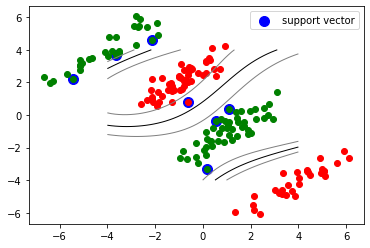

In [45]:
def plot_classifier(X1_train, X2_train):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "go")
    plt.scatter(sv_x[:,0], sv_x[:,1], s=100, c="blue", edgecolors="b", label="support vector")

    X1, X2 = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.legend()
    plt.show()
    
plot_classifier(X_train[y_train==1], X_train[y_train==-1])

In [46]:
from sklearn.metrics import accuracy_score
y_pred = predict(X_test)
print('Accuracy of non-linear svm based on cvxopt: ', accuracy_score(y_test, y_pred))

Accuracy of non-linear svm based on cvxopt:  1.0
